In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.core.display import display, HTML
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import json, sys, math, glob
from scipy.stats import t as ttest

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.max_open_warning'] = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.path.insert(0, "/home/m092926/daisy/Documents/ml_perf_model/")
from analysis.utils import PM_HOME, GPU_NAME
from analysis.trace_utils import *

In [6]:
root_dir = '{}/data/{}/e2e'.format(PM_HOME, GPU_NAME)
overheads_files = glob.glob("{}/*/*_overheads.json".format(root_dir))
alpha = 0.05
eps = 1e-5
truncated_count = 10

def get_p_value(a, b):
    """
        a: tuple of 3 (mean, std, count)
        b: tuple of 3 (mean, std, count)
    """
    xa, sa, na = a
    xb, sb, nb = b
    t_stat = (xa - xb) / math.sqrt((sa * sa / na + sb * sb / nb + eps))
    # degrees of freedom
    df = na + nb - 2
    # calculate the p-value
    p = (1 - ttest.cdf(abs(t_stat), df)) * 2.0
    return p
# get_p_value((1.3, 0.5, 22), (1.6, 0.3, 24)) # 0.0188

def get_two_sample_ttest_hotmap(data):
    array = np.ones((len(data), len(data)))
    for idxa, a in enumerate(data):
        for idxb, b in enumerate(data):
            p = get_p_value(a[1], b[1])
            if p < alpha: # means they are not the same distribution (null hypothesis rejected)
                array[idxa, idxb] = 0
                array[idxb, idxa] = 0
    return array


In [15]:
o_stats = {
    't1': {},
    't2': {},
    't3': {},
    't4': {},
    't5': {}
}

for overheads_file in overheads_files:
    model_name = overheads_file.split('/')[-2]
    batch_size = overheads_file.split('/')[-1].split('_')[1]

    with open(overheads_file) as f:
        overheads = json.load(f)

    for t in o_stats.keys():
        if t == 't1':
            o_stats[t][(model_name, batch_size)] = overheads[t]
        elif t == 't4':
            for runtime_f, s in overheads[t].items():
                if runtime_f not in o_stats[t].keys():
                    o_stats[t][runtime_f] = {}
                o_stats[t][runtime_f][(model_name, batch_size)] = s
        else:
            for op_name, s in overheads[t].items():
                bw_truncated_name = op_name.split("autograd::engine::evaluate_function: ")[-1]
                if bw_truncated_name not in o_stats[t].keys():
                    o_stats[t][bw_truncated_name] = {}
                if s[0] != 0:
                    o_stats[t][bw_truncated_name][(model_name, batch_size)] = s

for t in ['t2', 't3', 't5']:
    # Remove trivial stats
    del_names = []
    for k, v in o_stats[t].items():
        if len(v.keys()) <= 3:
            del_names.append(k)
    for k in del_names:
        del o_stats[t][k]

### T1

In [19]:
pprint(o_stats['t1'])

{('DLRM_DDP', '1024'): [9.959410029498525, 5.048017655258846, 8475],
 ('DLRM_DDP', '16384'): [10.9091054568731, 14.539335688713004, 12498],
 ('DLRM_DDP', '2048'): [9.517742124370535, 5.33937881810885, 8539],
 ('DLRM_DDP', '4096'): [7.244784064565983, 6.07496683117049, 11647],
 ('DLRM_DDP', '512'): [7.783657457641265, 6.484817167497398, 11981],
 ('DLRM_DDP', '8192'): [10.85912, 14.678280308864522, 12500],
 ('DLRM_MLPerf', '1024'): [9.871636575422247, 5.42444845682035, 8585],
 ('DLRM_MLPerf', '16384'): [10.53136, 13.89478954681934, 12500],
 ('DLRM_MLPerf', '2048'): [9.379599441080577, 5.23613908502325, 8588],
 ('DLRM_MLPerf', '256'): [10.931910112359551, 9.24221347051759, 8900],
 ('DLRM_MLPerf', '4096'): [7.680562573690416, 6.106718756158573, 11874],
 ('DLRM_MLPerf', '512'): [7.457207775814188, 5.999137292139347, 11883],
 ('DLRM_MLPerf', '8192'): [10.34592, 13.669130892401316, 12500],
 ('DLRM_default', '1024'): [9.957333333333333, 5.920609609832993, 7125],
 ('DLRM_default', '16384'): [12

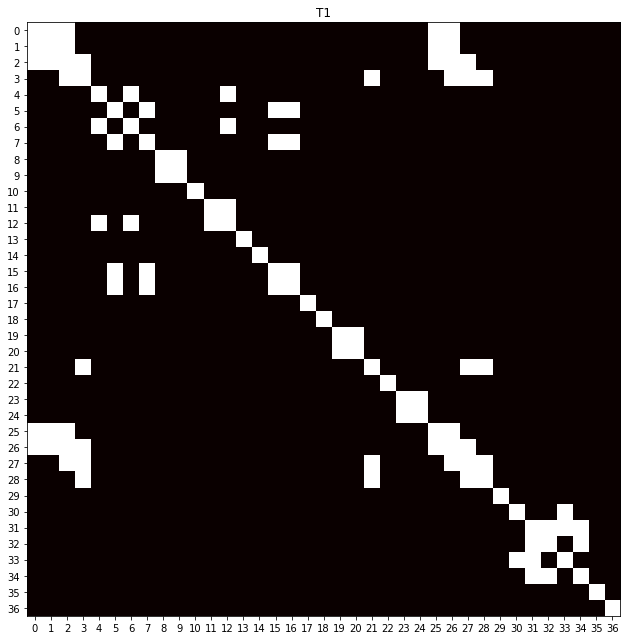

In [16]:
plt.figure()
ax = plt.gca()
tmp = sorted(o_stats['t1'].items(), key=lambda x: x[1][0] * x[1][2])
hotmap = get_two_sample_ttest_hotmap(tmp)
ax.imshow(hotmap, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
ax.title.set_text("T1")
ax.set_xticks(range(0, len(tmp)))
ax.set_yticks(range(0, len(tmp)))
plt.tight_layout()

### T2, T3, T5

In [17]:
pprint(o_stats['t2'])

{'AddmmBackward0': {('DLRM_DDP', '1024'): [43.24090338770389,
                                           6.207388901592166,
                                           797],
                    ('DLRM_DDP', '16384'): [45.85125, 43.08420967637099, 800],
                    ('DLRM_DDP', '2048'): [45.09398496240601,
                                           8.57342977781718,
                                           798],
                    ('DLRM_DDP', '4096'): [45.19419924337957,
                                           8.524728018464955,
                                           793],
                    ('DLRM_DDP', '512'): [43.976100628930816,
                                          6.353580272506361,
                                          795],
                    ('DLRM_DDP', '8192'): [48.57875, 9.86654946967277, 800],
                    ('DLRM_MLPerf', '1024'): [45.461635220125785,
                                              7.374917534915889,
                        

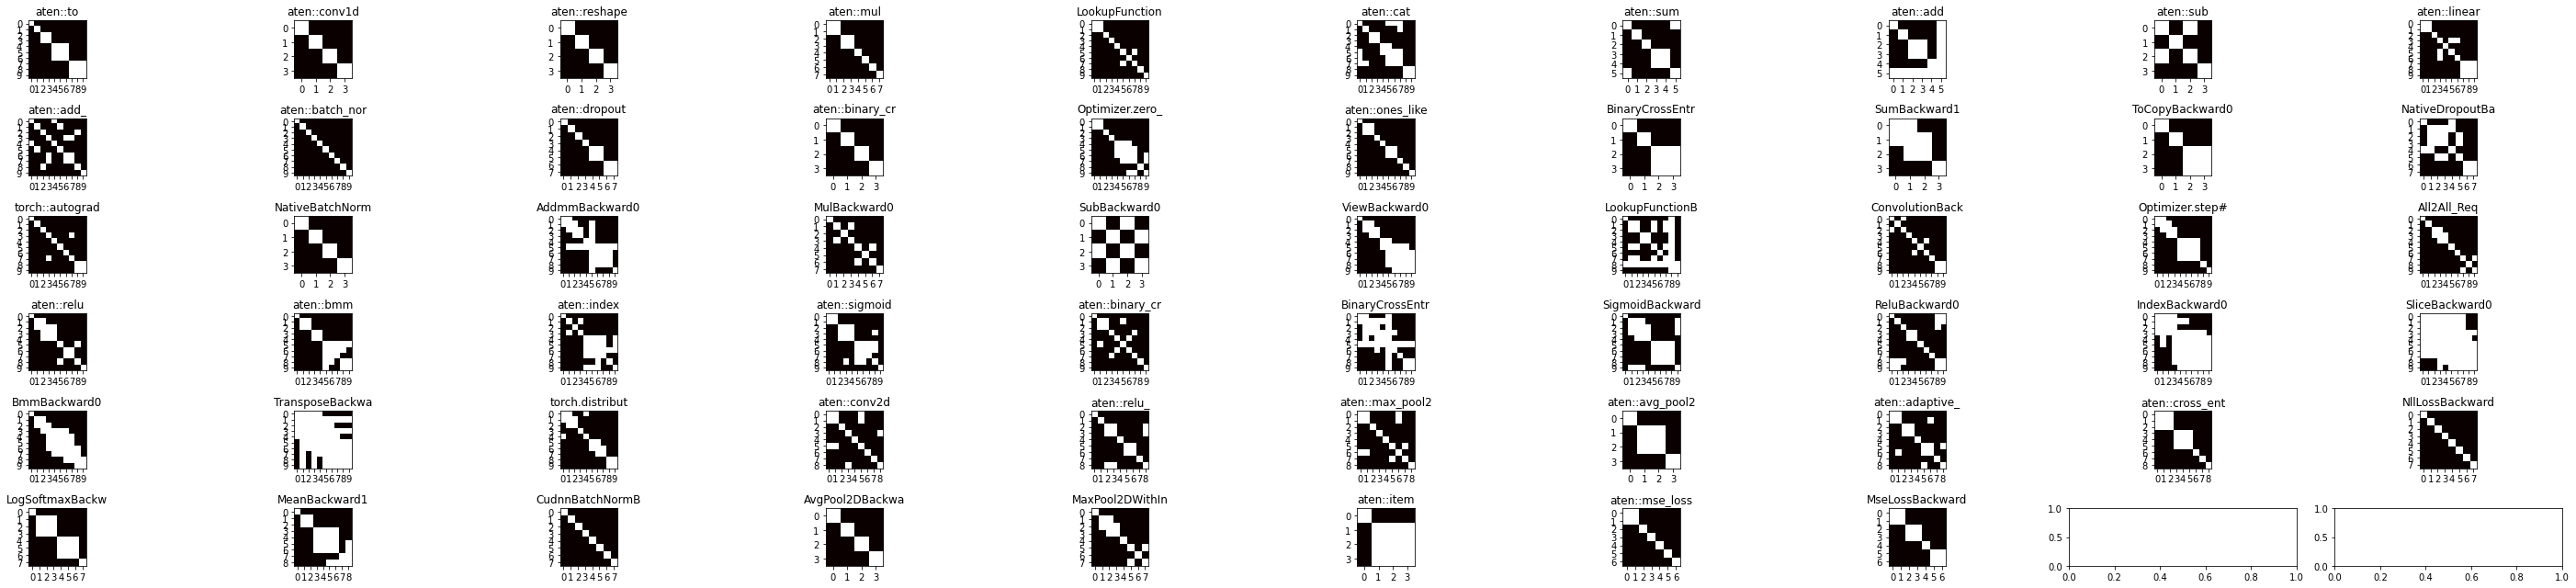

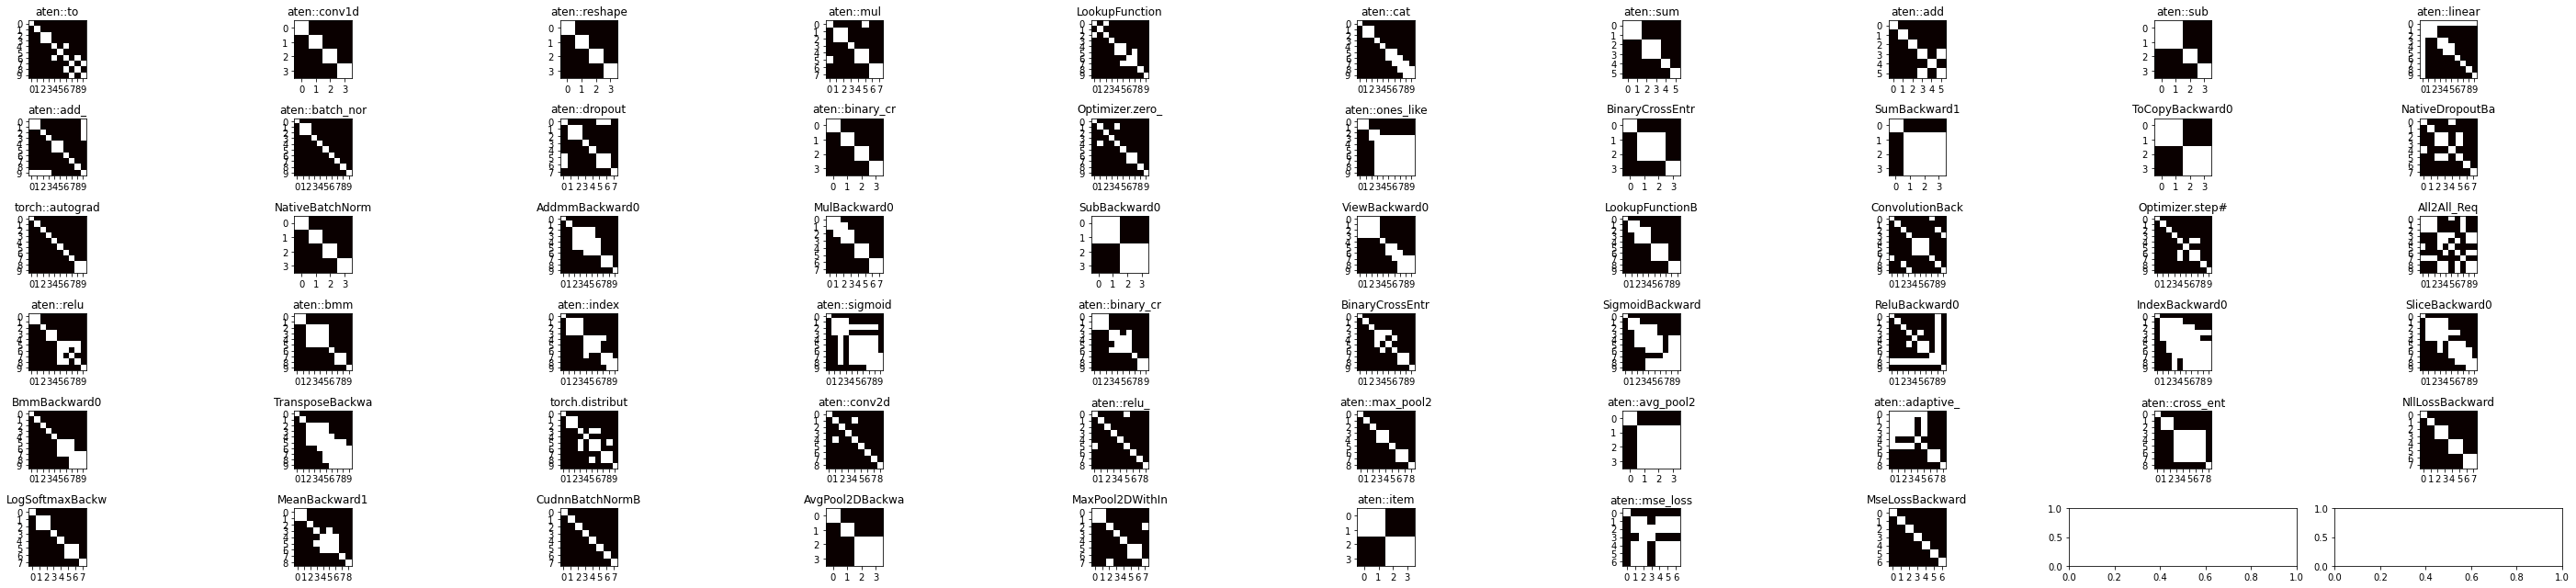

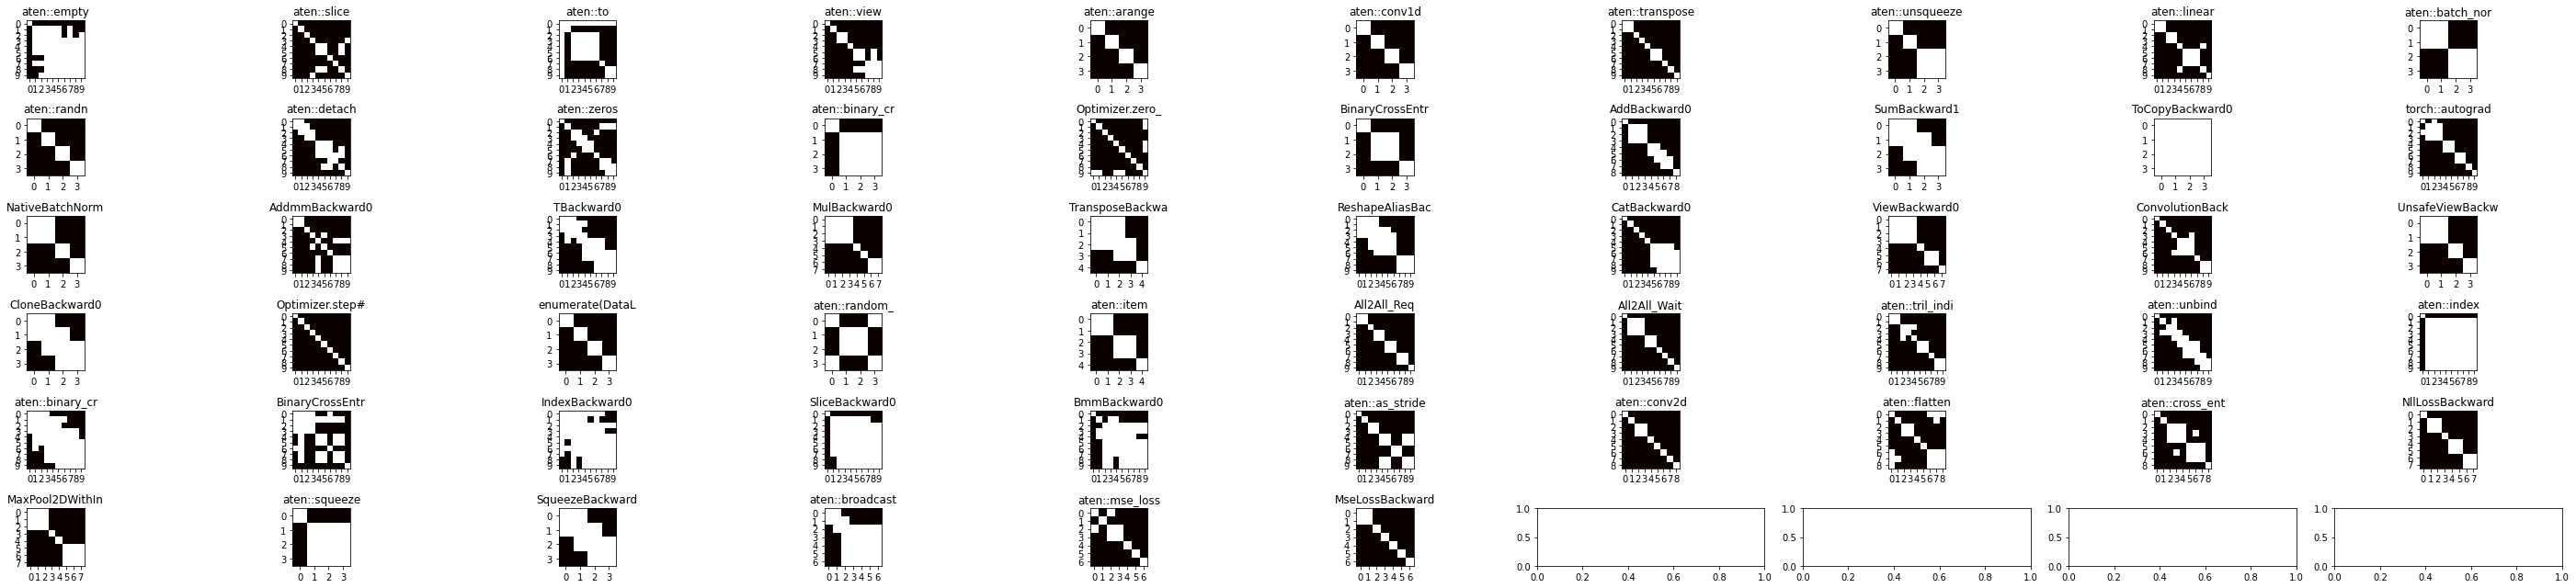

In [18]:
for t in ['t2', 't3', 't5']:
    ncols = truncated_count
    nrows = math.ceil(len(o_stats[t].keys()) / ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

    count = 0
    for op_name, s in o_stats[t].items():
        t = sorted(s.items(), key=lambda vv: -vv[1][0] * vv[1][2])
        tmp = t[:truncated_count]
        hotmap = get_two_sample_ttest_hotmap(tmp)
        ax = axs[count // ncols, count % ncols]
        ax.imshow(hotmap, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        ax.title.set_text(op_name[:15])
        ax.set_xticks(range(0, len(tmp)))
        ax.set_yticks(range(0, len(tmp)))
        count += 1

    plt.tight_layout()
plt.rcParams['figure.figsize'] = [ncols * 4, nrows]